# Apparent Magnitude Validation

In [1]:
import pandas as pd
import numpy as np
import astropy.units as u
from astroquery.jplhorizons import Horizons
from sorcha.modules.PPCalculateApparentMagnitudeInFilter import PPCalculateApparentMagnitudeInFilter
import matplotlib.pyplot as plt

To test the calculation of the apparent magnitude in the code, we can compare them to the apparent magnitudes calculated by JPL Horizons.

First, let's get the JPL Horizons ephemeris for a test object. PPCalculateApparentMagnitudeInFilter uses sbpy's photometry module to calculate phase functions, and sbpy's unit tests use 24 Themis as a test object. We will do the same.

In [2]:
obj = Horizons(id='Themis', id_type='name', location='I11',

               epochs={'start':'2021-01-01', 'stop':'2023-01-01',

                       'step':'1d'})

eph = obj.ephemerides(quantities='9,19,20,43')
jpl_eph = eph.to_pandas()
jpl_eph

,targetname,datetime_str,datetime_jd,H,G,solar_presence,lunar_presence,V,surfbright,r,r_rate,delta,delta_rate,alpha_true,PABLon,PABLat
0,24 Themis (A853 GA),2021-Jan-01 00:00,2459215.5,7.24,0.19,C,,13.318,7.112,3.275241,1.868767,4.212453,-4.641369,4.5918,262.7496,-0.4684
1,24 Themis (A853 GA),2021-Jan-02 00:00,2459216.5,7.24,0.19,C,,13.327,7.122,3.276319,1.866016,4.209518,-4.922596,4.7832,263.0067,-0.4700
2,24 Themis (A853 GA),2021-Jan-03 00:00,2459217.5,7.24,0.19,C,,13.335,7.132,3.277396,1.863252,4.206423,-5.203712,4.9741,263.2635,-0.4716
3,24 Themis (A853 GA),2021-Jan-04 00:00,2459218.5,7.24,0.19,C,,13.344,7.142,3.278471,1.860476,4.203166,-5.484783,5.1645,263.5200,-0.4732
4,24 Themis (A853 GA),2021-Jan-05 00:00,2459219.5,7.24,0.19,C,,13.352,7.152,3.279545,1.857687,4.199749,-5.765845,5.3543,263.7760,-0.4748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,24 Themis (A853 GA),2022-Dec-28 00:00,2459941.5,7.24,0.19,C,m,13.480,7.626,3.407801,-1.337567,3.548593,23.738198,16.0868,357.7423,-0.3756
727,24 Themis (A853 GA),2022-Dec-29 00:00,2459942.5,7.24,0.19,C,m,13.485,7.624,3.407028,-1.341288,3.562140,23.633204,16.0210,357.9249,-0.3731
728,24 Themis (A853 GA),2022-Dec-30 00:00,2459943.5,7.24,0.19,C,m,13.491,7.621,3.406252,-1.345002,3.575623,23.523879,15.9522,358.1090,-0.3707
729,24 Themis (A853 GA),2022-Dec-31 00:00,2459944.5,7.24,0.19,C,m,13.496,7.619,3.405474,-1.348708,3.589039,23.410433,15.8807,358.2945,-0.3683


This needs to be turned into a form the function can understand. Values for G1, G2 and G12 are from Muinonen et al. (2010).

In [3]:
observations_df = pd.DataFrame({'MJD':jpl_eph['datetime_jd'] - 2_400_000.5,
                                'H_filter': jpl_eph['H'],
                                'GS': jpl_eph['G'],
                                'G1': np.zeros(len(jpl_eph['G'])) + 0.62,
                                'G2': np.zeros(len(jpl_eph['G'])) + 0.14,
                                'G12': np.zeros(len(jpl_eph['G'])) + 0.68,
                                'JPL_mag': jpl_eph['V'],
                                'Range_LTC_km': jpl_eph['r'] * 1.495978707e8,
                                'Obj_Sun_LTC_km': jpl_eph['delta'] * 1.495978707e8,
                                'phase_deg': jpl_eph['alpha_true']})

In [4]:
observations_df

,MJD,H_filter,GS,G1,G2,G12,JPL_mag,Range_LTC_km,Obj_Sun_LTC_km,phase_deg
0,59215.0,7.24,0.19,0.62,0.14,0.68,13.318,4.899690e+08,6.301739e+08,4.5918
1,59216.0,7.24,0.19,0.62,0.14,0.68,13.327,4.901304e+08,6.297350e+08,4.7832
2,59217.0,7.24,0.19,0.62,0.14,0.68,13.335,4.902915e+08,6.292719e+08,4.9741
3,59218.0,7.24,0.19,0.62,0.14,0.68,13.344,4.904523e+08,6.287847e+08,5.1645
4,59219.0,7.24,0.19,0.62,0.14,0.68,13.352,4.906130e+08,6.282735e+08,5.3543
...,...,...,...,...,...,...,...,...,...,...
726,59941.0,7.24,0.19,0.62,0.14,0.68,13.480,5.097998e+08,5.308620e+08,16.0868
727,59942.0,7.24,0.19,0.62,0.14,0.68,13.485,5.096841e+08,5.328886e+08,16.0210
728,59943.0,7.24,0.19,0.62,0.14,0.68,13.491,5.095680e+08,5.349056e+08,15.9522
729,59944.0,7.24,0.19,0.62,0.14,0.68,13.496,5.094517e+08,5.369125e+08,15.8807


Now we calculate the magnitude using the various models in PPCalculateApparentMagnitudeInFilter.

In [5]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'HG', 'r', 'HG_mag')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'HG12', 'r', 'HG12_mag')
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'HG1G2', 'r', 'HG1G2_mag')

In [6]:
observations_df

,MJD,H_filter,GS,G1,G2,G12,JPL_mag,Range_LTC_km,Obj_Sun_LTC_km,phase_deg,HG_mag,HG12_mag,HG1G2_mag
0,59215.0,7.24,0.19,0.62,0.14,0.68,13.318,4.899690e+08,6.301739e+08,4.5918,13.331578,13.327267,13.316821
1,59216.0,7.24,0.19,0.62,0.14,0.68,13.327,4.901304e+08,6.297350e+08,4.7832,13.341366,13.336490,13.326087
2,59217.0,7.24,0.19,0.62,0.14,0.68,13.335,4.902915e+08,6.292719e+08,4.9741,13.350778,13.345410,13.335072
3,59218.0,7.24,0.19,0.62,0.14,0.68,13.344,4.904523e+08,6.287847e+08,5.1645,13.359831,13.354037,13.343783
4,59219.0,7.24,0.19,0.62,0.14,0.68,13.352,4.906130e+08,6.282735e+08,5.3543,13.368535,13.362378,13.352227
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,59941.0,7.24,0.19,0.62,0.14,0.68,13.480,5.097998e+08,5.308620e+08,16.0868,13.481646,13.518557,13.522578
727,59942.0,7.24,0.19,0.62,0.14,0.68,13.485,5.096841e+08,5.328886e+08,16.0210,13.487347,13.523931,13.527875
728,59943.0,7.24,0.19,0.62,0.14,0.68,13.491,5.095680e+08,5.349056e+08,15.9522,13.492879,13.529119,13.532982
729,59944.0,7.24,0.19,0.62,0.14,0.68,13.496,5.094517e+08,5.369125e+08,15.8807,13.498251,13.534132,13.537910


Now we can plot the magnitudes and compare them.

Note that we do not expect any of the calculated magnitudes to match JPL Horizons exactly. JPL Horizons uses the IAU simplification of the HG model to calculate apparent magnitude, while sbpy uses the original HG formulation from Bowell et al. (1989). However, they should all be a close match.

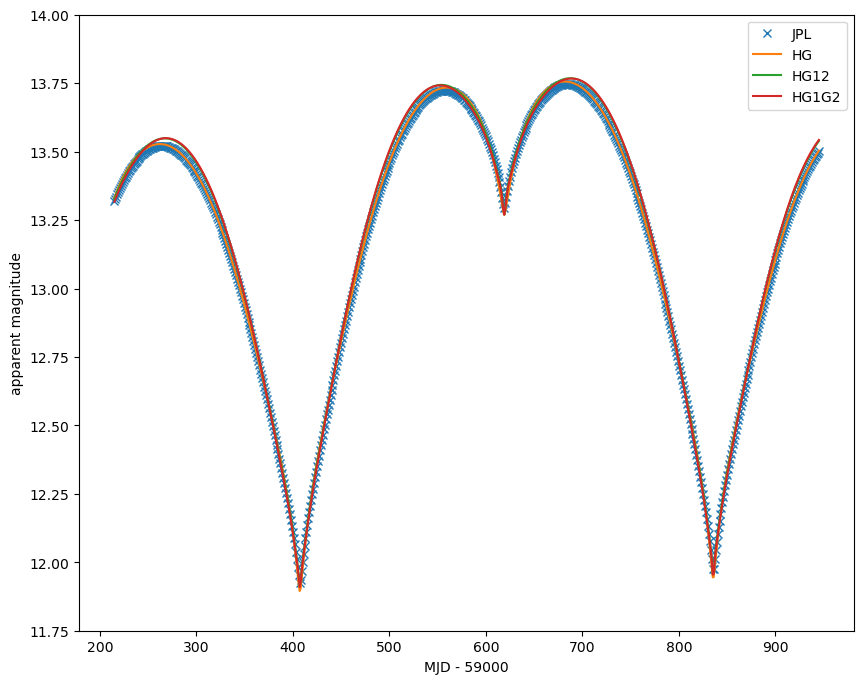

In [7]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(observations_df["MJD"] - 59000, observations_df["JPL_mag"], linestyle="", marker="x", label="JPL")
ax.plot(observations_df["MJD"] - 59000, observations_df["HG_mag"], label="HG")
ax.plot(observations_df["MJD"] - 59000, observations_df["HG12_mag"], label="HG12")
ax.plot(observations_df["MJD"] - 59000, observations_df["HG1G2_mag"], label="HG1G2")
ax.legend()
ax.set_xlabel("MJD - 59000")
ax.set_ylabel("apparent magnitude")
ax.set_ylim((11.75, 14))
plt.show()

To test the linear phase function model, we simply define a slope. We will use the same values for Themis and arbitrarily choose S to be 0.04.

In [8]:
H = observations_df['H_filter'].values
alpha = observations_df['phase_deg'].values
r = observations_df['Range_LTC_km'].values / 1.495978707e8
delta = observations_df['Obj_Sun_LTC_km'].values / 1.495978707e8
S = np.zeros(len(H)) + 0.04

observations_df["S"] = S

The expected apparent magnitude will thus take the form:

$m = H + 5 \log_{10}(\Delta) + 5 \log_{10}(r) + S\alpha$

In [9]:
linear_mag_calc = 5. * np.log10(delta) + 5. * np.log10(r) + H + (S * alpha)

Calculating using the linear phase function model in PPCalculateApparentMagnitudeInFilter...

In [10]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), 'linear', 'r', 'linear_mag')

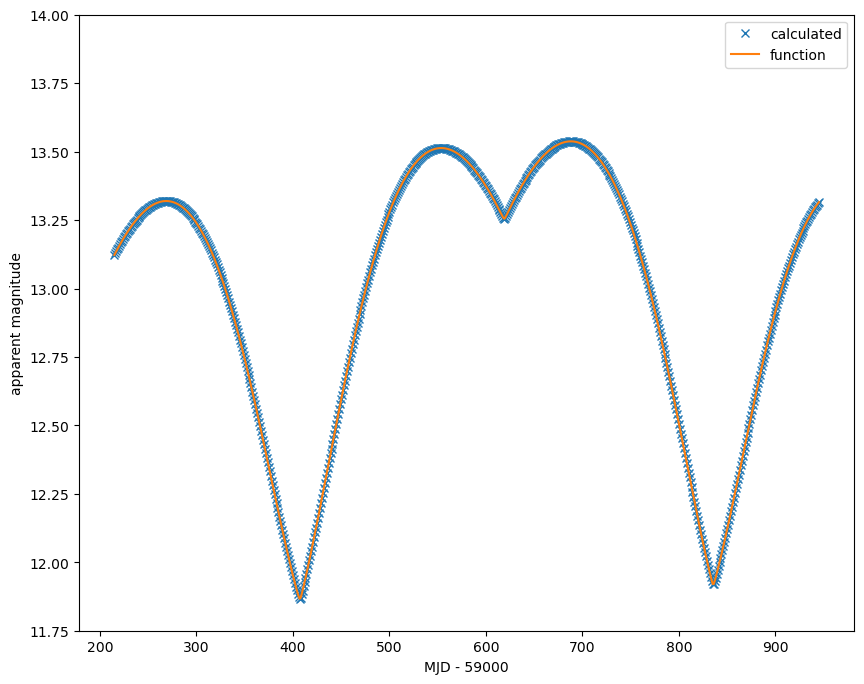

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(observations_df["MJD"] - 59000, linear_mag_calc, linestyle="", marker="x", label="calculated")
ax.plot(observations_df["MJD"] - 59000, observations_df["linear_mag"], label="function")
ax.legend()
ax.set_xlabel("MJD - 59000")
ax.set_ylabel("apparent magnitude")
ax.set_ylim((11.75, 14))
plt.show()

Note that there is some offset (20-40 mmag) between the `sorcha` predicted magnitudes using the HG/HG12/HG1G2 phase curves and the JPL magnitudes. This is not a bug in `sorcha`, but rather something in JPL (that is presumably using a more sophisticated model). To show that this is the case, we'll test these values out using an independent implementation of the three phase curve models. 

In [12]:
from scipy.interpolate import CubicSpline

A = [3.332, 1.862]
B = [0.631, 1.218]
C = [0.986, 0.238]

alpha_12 = np.deg2rad([7.5, 30., 60, 90, 120, 150])

phi_1_sp = [7.5e-1, 3.3486016e-1, 1.3410560e-1, 5.1104756e-2, 2.1465687e-2, 3.6396989e-3]
phi_1_derivs = [-1.9098593, -9.1328612e-2]

phi_2_sp = [9.25e-1, 6.2884169e-1, 3.1755495e-1, 1.2716367e-1, 2.2373903e-2, 1.6505689e-4]
phi_2_derivs = [-5.7295780e-1, -8.6573138e-8]

alpha_3 = np.deg2rad([0.0, 0.3, 1., 2., 4., 8., 12., 20., 30.])

phi_3_sp = [1., 8.3381185e-1, 5.7735424e-1, 4.2144772e-1, 2.3174230e-1, 1.0348178e-1, 6.1733473e-2, 1.6107006e-2, 0.]
phi_3_derivs = [-1.0630097, 0]


phi_1 = CubicSpline(alpha_12, phi_1_sp, bc_type=((1,phi_1_derivs[0]),(1,phi_1_derivs[1])))
phi_2 = CubicSpline(alpha_12, phi_2_sp, bc_type=((1,phi_2_derivs[0]),(1,phi_2_derivs[1])))
phi_3 = CubicSpline(alpha_3, phi_3_sp, bc_type=((1,phi_3_derivs[0]),(1,phi_3_derivs[1])))

def HG_model(phase, params):
    sin_a = np.sin(phase)
    tan_ah = np.tan(phase/2)
    
    W = np.exp(-90.56 * tan_ah * tan_ah)    
    scale_sina = sin_a/(0.119 + 1.341*sin_a - 0.754*sin_a*sin_a)
    
    phi_1_S = 1 - C[0] * scale_sina
    phi_2_S = 1 - C[1] * scale_sina
    
    phi_1_L = np.exp(-A[0] * np.power(tan_ah, B[0]))
    phi_2_L = np.exp(-A[1] * np.power(tan_ah, B[1]))
    
    phi_1 = W * phi_1_S + (1-W) * phi_1_L
    phi_2 = W * phi_2_S + (1-W) * phi_2_L
    return params[0] - 2.5*np.log10((1-params[1])* phi_1 + (params[1]) * phi_2) 


def HG1G2_model(phase, params):

    tan_ah = np.tan(phase/2)

    phi_1_ev = phi_1(phase)  
    phi_2_ev = phi_2(phase)  
    phi_3_ev = phi_3(phase)  

    msk = phase < 7.5 * np.pi/180

    phi_1_ev[msk] = 1-6*phase[msk]/np.pi 
    phi_2_ev[msk] = 1- 9 * phase[msk]/(5*np.pi)

    phi_3_ev[phase > np.pi/6] = 0


    return params[0] - 2.5 * np.log10(params[1] * phi_1_ev + params[2] * phi_2_ev + (1-params[1]-params[2]) * phi_3_ev)

def HG12_model(phase, params): 
    if params[1] >= 0.2:
        G1 = +0.9529*params[1] + 0.02162 
        G2 = -0.6125*params[1] + 0.5572
    else:
        G1 = +0.7527*params[1] + 0.06164  
        G2 = -0.9612*params[1] + 0.6270

    return HG1G2_model(phase, [params[0], G1, G2])

def HG12star_model(phase, params):
    G1 = 0 + params[1] * 0.84293649
    G2 = 0.53513350 - params[1] * 0.53513350
    
    return HG1G2_model(phase, [params[0], G1, G2])

In [13]:
observations_df['independent_HG'] = observations_df['H_filter'] + 5 * np.log10(observations_df['Range_LTC_km'] * observations_df['Obj_Sun_LTC_km']/(1.495978707e8**2)) + HG_model(observations_df['phase_deg'] * np.pi/180, [0,0.19])
observations_df['independent_HG12'] = observations_df['H_filter'] + 5 * np.log10(observations_df['Range_LTC_km'] * observations_df['Obj_Sun_LTC_km']/(1.495978707e8**2)) + HG12_model(observations_df['phase_deg'] * np.pi/180, [0,0.68])
observations_df['independent_HG12star'] = observations_df['H_filter'] + 5 * np.log10(observations_df['Range_LTC_km'] * observations_df['Obj_Sun_LTC_km']/(1.495978707e8**2)) + HG12star_model(observations_df['phase_deg'] * np.pi/180, [0,0.68])
observations_df['independent_HG1G2'] = observations_df['H_filter'] + 5 * np.log10(observations_df['Range_LTC_km'] * observations_df['Obj_Sun_LTC_km']/(1.495978707e8**2)) + HG1G2_model(observations_df['phase_deg'] * np.pi/180, [0,0.62, 0.14])

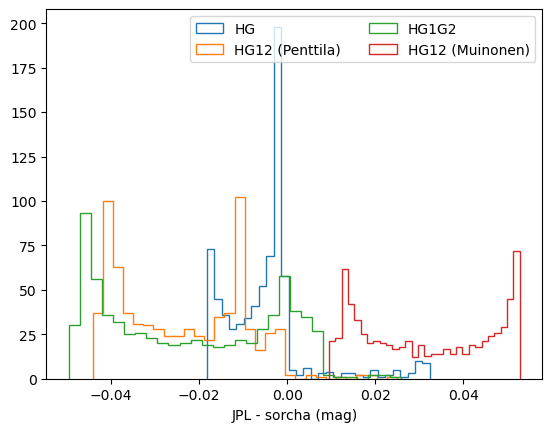

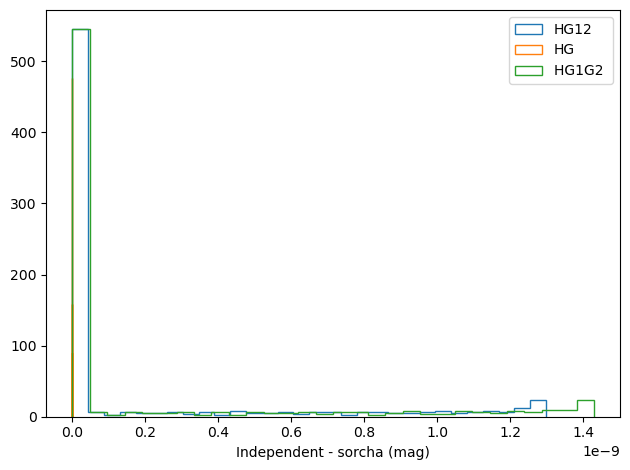

In [14]:
plt.hist(observations_df['JPL_mag'] - observations_df['HG_mag'], bins=30, histtype='step', label='HG')
plt.hist(observations_df['JPL_mag'] - observations_df['HG12_mag'], bins=30, histtype='step', label='HG12 (Penttila)')
plt.hist(observations_df['JPL_mag'] - observations_df['HG1G2_mag'], bins=30, histtype='step', label='HG1G2')
plt.hist(observations_df['JPL_mag'] - observations_df['independent_HG12'], bins=30, histtype='step', label='HG12 (Muinonen)')

plt.legend(ncol=2)
plt.xlabel('JPL - sorcha (mag)')
plt.show()


plt.hist(observations_df['HG12_mag'] - observations_df['independent_HG12star'], bins=30, histtype='step', label='HG12')
plt.hist(observations_df['HG_mag'] - observations_df['independent_HG'], bins=30, histtype='step', label='HG')
plt.hist(observations_df['HG1G2_mag'] - observations_df['independent_HG1G2'], bins=30, histtype='step', label='HG1G2 ')
plt.xlabel('Independent - sorcha (mag)')

plt.legend()
plt.tight_layout()
plt.show()

So the differences are $< 10^{-9}$ between the two implementations.